# Introduction

In [1]:
'''Importing Data Manipulattion Moduls'''
import numpy as np
import pandas as pd
from scipy import stats
import os, gc

'''Seaborn and Matplotlib Visualization'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")                    
%matplotlib inline

'''Display markdown formatted output like bold, italic bold etc.'''
from IPython.display import Markdown
def bold(string):
    display(Markdown(string))

In [2]:
import pickle
from tqdm import tqdm

# Data preparation

## CSV pd read

In [3]:
'''Read the dataset from csv file'''
building = pd.read_csv('../raw_data/building_metadata.csv')
weather_train = pd.read_csv('../raw_data/weather_train.csv')
weather_test = pd.read_csv('../raw_data/weather_test.csv')
train = pd.read_csv('../raw_data/train.csv') 
test = pd.read_csv('../raw_data/test.csv')

In [4]:
'''Dimension of train and test data'''
bold('**Shape of our train and test data**')
print('Dimension of building:', building.shape) 
print('Dimension of Weather train:',weather_train.shape) 
print('Dimension of Weather test:', weather_test.shape)
print('Dimension of train:',train.shape) 
print('Dimension of test:',test.shape)

**Shape of our train and test data**

Dimension of building: (1449, 6)
Dimension of Weather train: (139773, 9)
Dimension of Weather test: (277243, 9)
Dimension of train: (20216100, 4)
Dimension of test: (41697600, 4)


## Data minification → Reduce memory usage (downcasting) / load data faster, pickle format?

## merge/concat dataset on building ID, foreign key for building data and site ID, foreign key for weather data

In [5]:
#weather["timestamp"] = pd.to_datetime(weather["timestamp"])

In [8]:
'''Merging datasets'''
train = train.merge(building, on = 'building_id', how = 'left')
test = test.merge(building, on = 'building_id', how = 'left')

train = train.merge(weather_train, on = ['site_id', 'timestamp'], how = 'left')
test = test.merge(weather_test, on = ['site_id', 'timestamp'], how = 'left')

del weather_train, weather_test,building

## removing data from site 0 and potential other outliers?

# Features engineering & Modeling 

## Time / date

### convert to timestamp

In [9]:
train["timestamp"] = pd.to_datetime(train["timestamp"])

###  UTC to local time

In [10]:
train["isNaN"] = train["air_temperature"].isna().astype("int")
train.head()
train.shape
print('  Apply time zone')
site_id_to_time_zone = {
    0: "US/Eastern",
    1: "Europe/London",
    2: "US/Arizona",
    3: "US/Eastern",
    4: "US/Pacific",
    5: "Europe/London",
    6: "US/Eastern",
    7: "Canada/Eastern",
    8: "US/Eastern",
    9: "US/Central",
    10: "US/Pacific",
    11: "Canada/Eastern",
    12: "Europe/Dublin",
    13: "US/Central",
    14: "US/Eastern",
    15: "US/Eastern",
}

  Apply time zone


In [11]:
train["time_zone"] = train["site_id"].map(site_id_to_time_zone)
train.rename(columns={"timestamp": "timestamp_utc"}, inplace=True)
train["timestamp"] = train.apply(
    lambda x: x["timestamp_utc"]
    .tz_localize("UTC")
    .tz_convert(x["time_zone"])
    .tz_localize(None),
    axis="columns",
)

In [12]:
train.timestamp.dt.name

'timestamp'

### Expand timestamp: hours, day, weekday, month, year

In [13]:
train["hour"] = np.uint8(train["timestamp"].dt.hour)
train["day"] = np.uint8(train["timestamp"].dt.day)

#train["weekday_name"] = train["timestamp"].dt.weekday_name 
train["weekday"] = np.uint8(train["timestamp"].dt.weekday)
train["month"] = np.uint8(train["timestamp"].dt.month)

test["timestamp"] = pd.to_datetime(test["timestamp"])
test["hour"] = np.uint8(test["timestamp"].dt.hour)
test["day"] = np.uint8(test["timestamp"].dt.day)
test["weekday"] = np.uint8(test["timestamp"].dt.weekday)
test["month"] = np.uint8(test["timestamp"].dt.month)

In [14]:
train['weekday'].describe()

count    2.021610e+07
mean     3.005483e+00
std      1.996860e+00
min      0.000000e+00
25%      1.000000e+00
50%      3.000000e+00
75%      5.000000e+00
max      6.000000e+00
Name: weekday, dtype: float64

In [15]:
weekends = np.where(train['weekday'] > 4)
weekends

(array([   55224,    55225,    55226, ..., 20216097, 20216098, 20216099]),)

In [16]:
train['weekends'] = 0
train['weekends']

0           0
1           0
2           0
3           0
4           0
           ..
20216095    0
20216096    0
20216097    0
20216098    0
20216099    0
Name: weekends, Length: 20216100, dtype: int64

In [17]:
train['weekends'].iloc[weekends] = 1

/Users/anaflaviagama/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [18]:
train['weekends']

0           0
1           0
2           0
3           0
4           0
           ..
20216095    1
20216096    1
20216097    1
20216098    1
20216099    1
Name: weekends, Length: 20216100, dtype: int64

In [30]:
train.head(10)

,building_id,meter,timestamp_utc,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,wind_direction,wind_speed,isNaN,time_zone,timestamp,hour,day,weekday,month,weekends
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,...,0.0,0.0,0,US/Eastern,2015-12-31 19:00:00,19,31,3,12,0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,...,0.0,0.0,0,US/Eastern,2015-12-31 19:00:00,19,31,3,12,0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,...,0.0,0.0,0,US/Eastern,2015-12-31 19:00:00,19,31,3,12,0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,...,0.0,0.0,0,US/Eastern,2015-12-31 19:00:00,19,31,3,12,0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,...,0.0,0.0,0,US/Eastern,2015-12-31 19:00:00,19,31,3,12,0
5,5,0,2016-01-01,0.0,0,Education,8000,2000.0,NaN,25.0,...,0.0,0.0,0,US/Eastern,2015-12-31 19:00:00,19,31,3,12,0
6,6,0,2016-01-01,0.0,0,Lodging/residential,27926,1981.0,NaN,25.0,...,0.0,0.0,0,US/Eastern,2015-12-31 19:00:00,19,31,3,12,0
7,7,0,2016-01-01,0.0,0,Education,121074,1989.0,NaN,25.0,...,0.0,0.0,0,US/Eastern,2015-12-31 19:00:00,19,31,3,12,0
8,8,0,2016-01-01,0.0,0,Education,60809,2003.0,NaN,25.0,...,0.0,0.0,0,US/Eastern,2015-12-31 19:00:00,19,31,3,12,0
9,9,0,2016-01-01,0.0,0,Office,27000,2010.0,NaN,25.0,...,0.0,0.0,0,US/Eastern,2015-12-31 19:00:00,19,31,3,12,0


In [38]:
train['timestamp_utc'].describe()

/var/folders/jn/fmk11xqs3fqg4zt98nw043b80000gn/T/ipykernel_5647/3278292004.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  train['timestamp_utc'].describe()


count                20216100
unique                   8784
top       2016-12-27 22:00:00
freq                     2370
first     2016-01-01 00:00:00
last      2016-12-31 23:00:00
Name: timestamp_utc, dtype: object

### Holidays → Python package for hols in UK, US, CA, IR

In [33]:
! pip install holidays

  Using cached holidays-0.17-py3-none-any.whl (187 kB)
  Using cached korean_lunar_calendar-0.3.1-py3-none-any.whl (9.0 kB)
  Using cached hijri_converter-2.2.4-py3-none-any.whl (14 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl (47 kB)
  Using cached PyMeeus-0.5.11.tar.gz (5.4 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for pymeeus: filename=PyMeeus-0.5.11-py3-none-any.whl size=730974 sha256=c64210cf304f7c0c7468d83011b4934f71b9e8328dda226cfeb7a3be849b1638
  Stored in directory: /Users/anaflaviagama/Library/Caches/pip/wheels/8a/1f/aa/ac3580dfd3e704ad8dd67759214850410f4ea01c2b87344ddd
Successfully built pymeeus


In [34]:
from datetime import date
import holidays

In [44]:
for holiday_CA in holidays.CA(years=[2016]).items():
    print(holiday_CA)
for holiday_IE in holidays.IE(years=[2016]).items():
    print(holiday_IE)
for holiday_UK in holidays.UK(years=[2016]).items():
    print(holiday_UK)
for holiday_US in holidays.US(years=[2016]).items():
    print(holiday_US)

(datetime.date(2016, 1, 1), "New Year's Day")
(datetime.date(2016, 2, 15), 'Family Day')
(datetime.date(2016, 3, 25), 'Good Friday')
(datetime.date(2016, 3, 28), 'Easter Monday')
(datetime.date(2016, 5, 23), 'Victoria Day')
(datetime.date(2016, 7, 1), 'Canada Day')
(datetime.date(2016, 8, 1), 'Civic Holiday')
(datetime.date(2016, 9, 5), 'Labour Day')
(datetime.date(2016, 10, 10), 'Thanksgiving')
(datetime.date(2016, 12, 25), 'Christmas Day')
(datetime.date(2016, 12, 27), 'Christmas Day (Observed)')
(datetime.date(2016, 12, 26), 'Boxing Day')
(datetime.date(2016, 1, 1), "New Year's Day")
(datetime.date(2016, 3, 17), "St. Patrick's Day")
(datetime.date(2016, 3, 28), 'Easter Monday')
(datetime.date(2016, 5, 2), 'May Day')
(datetime.date(2016, 6, 6), 'June Bank Holiday')
(datetime.date(2016, 8, 1), 'August Bank Holiday')
(datetime.date(2016, 10, 31), 'October Bank Holiday')
(datetime.date(2016, 12, 25), 'Christmas Day')
(datetime.date(2016, 12, 26), "Christmas Day (Observed), St. Stephen's

## Potential drop of features : sea levels, winds?

In [27]:
train['floor_count'].value_counts()

1.0     934303
2.0     691052
4.0     351938
3.0     331688
6.0     296598
5.0     253856
8.0     175258
7.0     131435
9.0      86416
11.0     61465
13.0     43911
10.0     34880
21.0     26343
19.0     26343
26.0     26321
12.0     17559
16.0      8784
14.0      8783
Name: floor_count, dtype: int64

(array([10.,  2.,  1.,  3.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([  8783., 101335., 193887., 286439., 378991., 471543., 564095.,
        656647., 749199., 841751., 934303.]),
 <BarContainer object of 10 artists>)

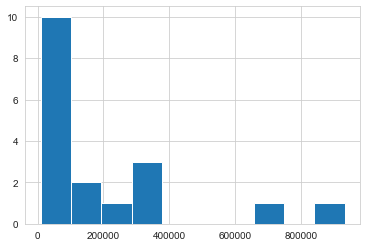

In [46]:
plt.hist(train['floor_count'].value_counts())

# Encoding & scaling variables

## Primary use to encode

## Scaling for some features?

# Handling missing values

## floor count

## year built

## cloud coverage and other weather: interpolation?

# Wrangling the data (esp. target)

## Meters data skewed by outliers → remove

## Log transforming of meter readings

## Strange data in some meters readings

# Other